In [92]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [83]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]

font = {'size'   : 15, }
axes = {'labelsize': 'large', 'titlesize': 'large'}

mpl.rc('font', **font)
mpl.rc('axes', **axes)

import pandas as pd
import data_utils
import matplotlib.style as style

In [2]:
experiment_number = 6

In [157]:
# Paths to data csvs
wd = "/home/behzad/Documents/barnes_lab/cplusplus_software/speed_test/repressilator/cpp/"
data_dir = wd + "output/two_species_stable_" + str(experiment_number) + "/Population_0/"

distances_path = data_dir + "/distances.csv"
eigenvalues_path = data_dir + "/eigenvalues_do_fsolve_state.csv"
model_space_report_path = data_dir + "/model_space_report.csv"

adj_mat_dir = "/home/behzad/Documents/barnes_lab/sympy_consortium_framework/output/two_species_no_symm/adj_matricies/model_#REF#_adj_mat.csv"
output_dir = wd + "/data_analysis_notebook/figures/figure_4_parts/"



In [153]:
# Load dataframes
distances_df = pd.read_csv(distances_path)
eigenvalues_df = pd.read_csv(eigenvalues_path)
model_space_report_df = pd.read_csv(model_space_report_path)

# Make distances numeric
distances_df = data_utils.distances_pre_processing(distances_df)

In [154]:
total_num_parts, num_AHL_parts, num_microcin_parts = data_utils.make_num_parts(model_space_report_df, 
                                                                               adj_mat_dir)
model_space_report_df['total_num_parts'] = total_num_parts
model_space_report_df['num_AHL_parts'] = num_AHL_parts
model_space_report_df['num_microcin_parts'] = num_microcin_parts


In [155]:
sub_df = model_space_report_df.loc[(model_space_report_df['num_AHL_parts'] == 2) &
                                   (model_space_report_df['num_microcin_parts'] ==2) & 
                                   (model_space_report_df['accepted_count'] > 2)]

model_indexes = model_space_report_df['model_idx'].values
KS_data_path_template = wd + "data_analysis_notebook/posterior_analysis/KS_data/model_NUM_KS.csv"


model_space_report_df['crit_param_1'] = np.nan
model_space_report_df['crit_param_2'] = np.nan
model_space_report_df['crit_param_3'] = np.nan

for model_idx in model_indexes:
    try:
        df = pd.read_csv(KS_data_path_template.replace('NUM', str(int(model_idx))), sep=',')
    
    except(FileNotFoundError, ValueError):
        continue
                         
    param_names = df.columns[3:]
    
    row = df.iloc[0]
    param_KS_values = row[3:].values
    max_param_idx = np.argmax(param_KS_values)
    
    max_param_value = round(param_KS_values[max_param_idx], 3)
    d_crit = round(row['D_crit'], 3)

    ind = np.argpartition(param_KS_values, -3)[-3:]
    
    params_order = [param for _,param in sorted(zip(param_KS_values,param_names), reverse=True)]
    
    critical_parameters = [param for param in params_order]
    
    model_space_report_df.loc[model_idx, 'crit_param_1'] = critical_parameters[0]
    model_space_report_df.loc[model_idx, 'crit_param_2'] = critical_parameters[1]
    model_space_report_df.loc[model_idx, 'crit_param_3'] = critical_parameters[2]

## Postieror analysis
1. Posterior and sample distributions generated for each model. 
2. Two-sample Kolmogorov-Smirnov (KS) test to quantify the difference between the sample and posterior distribution.
3. Critical value calculated for each paraemter for 0.05 significance (based on sample size).

Bar chart below shows counts for the top ranking critical parameter across all models - the parameter for which the posterior distribution has most divergence from the sample distribution. 

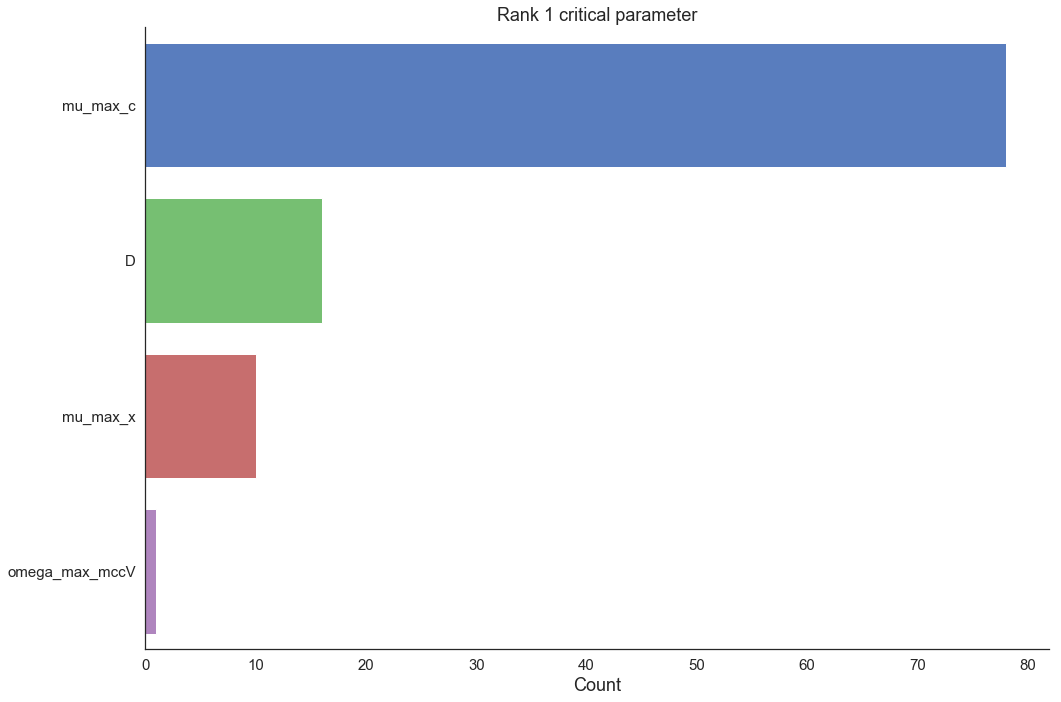

In [158]:
style.use('seaborn-muted')
current_palette = sns.color_palette()
sns.set_style("white")
# sns.set_context("poster")


fig, axes = plt.subplots(ncols=1)
crit_params = [1]

for idx, col_num in enumerate(crit_params):
    crit_param_col = 'crit_param_NUM'.replace('NUM', str(col_num))
    names = model_space_report_df[crit_param_col].value_counts().index
    value_counts = model_space_report_df[crit_param_col].value_counts()
    sns.barplot(value_counts, names, ax=axes)
    
    axes.spines["right"].set_visible(False)
    axes.spines["top"].set_visible(False)
    axes.set_title('Rank ' + str(col_num) + ' critical parameter')
    axes.tick_params(labelsize=15)
    axes.set_xlabel('Count')
    
plt.tight_layout()
plt.savefig(output_dir+'rank_one_params.pdf', dpi=500)
plt.show()

In [159]:
# Extract all parameter column names
all_param_names = []
for model_idx in model_indexes:
    try:
        df = pd.read_csv(KS_data_path_template.replace('NUM', str(int(model_idx))), sep=',')
        
    except(FileNotFoundError, ValueError):
        continue
        
    param_names = df.columns[3:]
    [all_param_names.append(p) for p in param_names]
    
all_param_names = list(set(all_param_names))

In [160]:
# Init dataframe
# normalised_KS_df = pd.DataFrame(columns=['param'], data=['n', 'norm_KS_mean', 'norm_stdev'])

# Store dicts of each row
rows_list = []
for param in all_param_names:
    normalised_KS_values = []
    
    for model_idx in model_indexes:
        try:
            df = pd.read_csv(KS_data_path_template.replace('NUM', str(int(model_idx))), sep=',')

        except(FileNotFoundError, ValueError):
            continue

        D_crit = df['D_crit']
        
        try:
            norm_KS_val = df[param]/D_crit            
            row_dict = {'param': param,
                       'norm_KS_val': norm_KS_val}
            rows_list.append(row_dict)

        
        except(KeyError):
            continue
    
    
normalised_KS_df = pd.DataFrame(rows_list)   

In [161]:
median_param_values = []
for param in all_param_names:
    vals = normalised_KS_df.loc[normalised_KS_df['param'] == param]['norm_KS_val'].values
    median = np.mean(vals)
    median_param_values.append([param, median])

median_param_values = sorted(median_param_values, key= lambda x: x[1], reverse=True)
params_order  = [i[0] for i in median_param_values]

Next, we normalise the KS values in each model to the critical value (0.05 signifncance). For normalised KS value above 1.0, the diveregence between the sample distribution and the posterior distribution is significant. 

Below are boxplot and violin plots, showing the parameters with the 5 highest mean KS values.

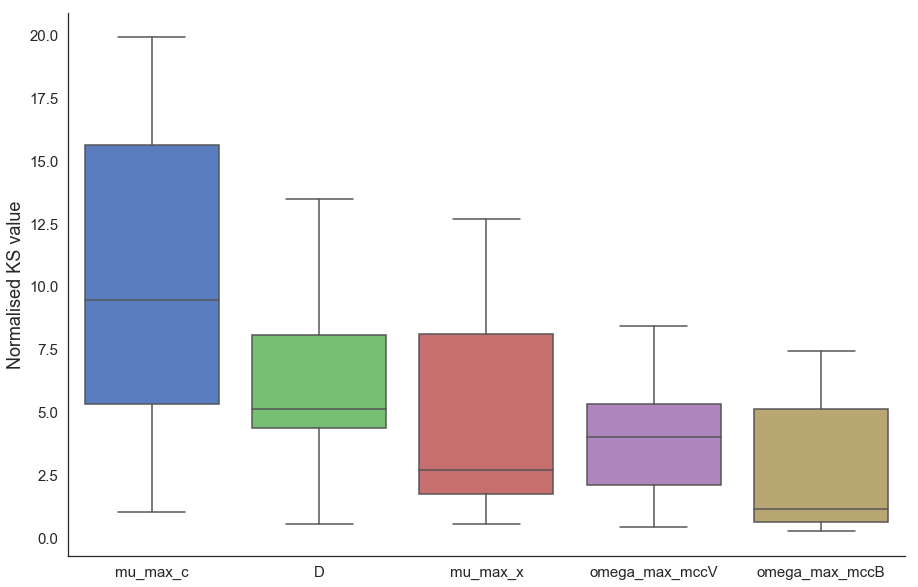

In [162]:
style.use('seaborn-muted')
sns.set_style("white")

normalised_KS_df['norm_KS_val'] = normalised_KS_df['norm_KS_val'].astype(float)
ax = sns.boxplot(x='param', y='norm_KS_val', data=normalised_KS_df, 
                 order=params_order[:5])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel(None)
ax.set_ylabel('Normalised KS value')
ax.tick_params(labelsize=15)
plt.savefig(output_dir+'boxplot_norm_KS_params.pdf', dpi=300)


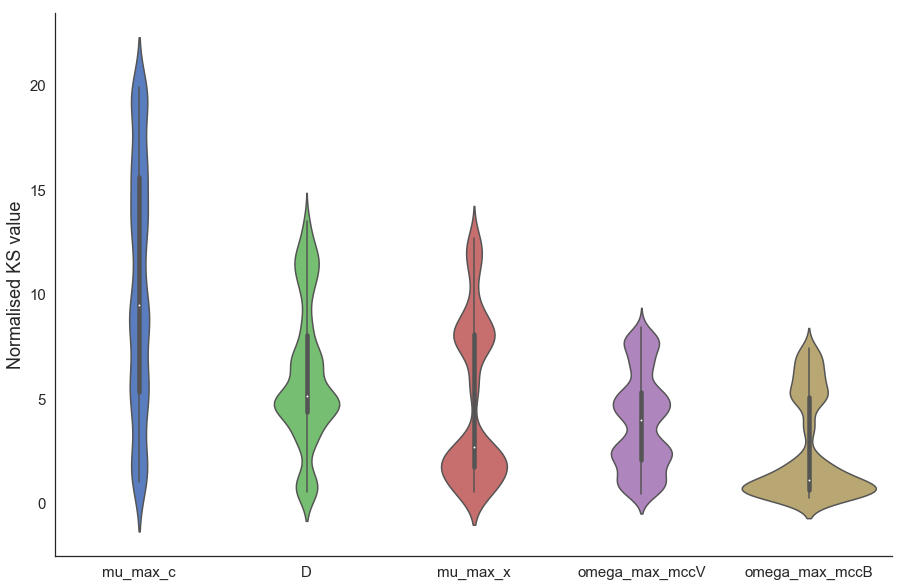

In [163]:
style.use('seaborn-muted')
sns.set_style("white")

normalised_KS_df['norm_KS_val'] = normalised_KS_df['norm_KS_val'].astype(float)
ax = sns.violinplot(x='param', y='norm_KS_val', data=normalised_KS_df, 
                    order=params_order[:5], 
                   bw=0.2)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel(None)
ax.set_ylabel('Normalised KS value')
ax.tick_params(labelsize=15)
plt.savefig(output_dir+'violin_norm_KS_params.pdf', dpi=500)

